# Installing packages
Running this cell will download the Easy-VQA dataset which can be accessed later


In [1]:
!pip install easy-vqa

     |████████████████████████████████| 3.2 MB 34.1 MB/s 


# Importing required libraries

In [2]:
import os
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
from easy_vqa import get_train_image_paths, get_test_image_paths
from easy_vqa import get_train_questions, get_test_questions
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

Loading the spacy model for tokenizing the question

In [3]:
spacy_eng = spacy.load("en")

# Dataloading and Vocabulary building

This class will be used to make vocabulary according to the words in the question. After building the vocabulary, the words in the sentences are replaced by their correspoding index from the vocab dictionary. The words that are present in the vocabulary are those which appear above a particular frequency, this frequency is an argument of the class.

In [19]:
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>", 1:"<SOS>" , 2:"<EOS>" , 3:"<UNK>", 4:"?"} #itos = index to string
    self.stoi = {"<PAD>":0 ,"<SOS>":1 ,"<EOS>":2 ,"<UNK>":3,"?":4 } #stoi = string to index
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.itos)

  def tokenizer_eng(self,text):
    lis = []
    for tok in text.split():
      if tok[-1]=="?":
        lis.append(tok[0:-1])
      else:
        lis.append(tok)
    return lis

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 5

    for sentence in sentence_list:
      for word in sentence.split():
        if word[-1]=="?":
          word = word[0:-1]
        if word not in frequencies:
          frequencies[word]=1
        else:
          frequencies[word]+=1
        if frequencies[word] == self.freq_threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx+=1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)
    liss = []
    for token in tokenized_text:
      liss.append(self.stoi[token])
    else:
      liss.append(self.stoi["<UNK>"])
    return liss

This class is the Dataloader for the model. The questions, answer and images are achieved from the `easy-VQA` package that we installed before. For more information on the package please refer the following link: [easy-vqa](https://pypi.org/project/easy-vqa/) 

In [39]:
class VQADataset(Dataset):
  def __init__(self, vocab, image_path, transforms=None, freq_threshold=1, train=True):
    self.image_path = image_path
    self.freq_threshold = freq_threshold
    self.transforms = transforms

    #get questions and answers
    if train:
      questions, answers, ids = get_train_questions()
    else:
      questions, answers, ids = get_test_questions()
    self.image_ids = ids
    self.questions = questions
    self.answers = answers

    #initialize vocab and build it
    if train:  
      self.vocab = Vocabulary(self.freq_threshold)
      self.vocab.build_vocabulary(questions)
    else:
      self.vocab = Vocabulary(self.freq_threshold)
      self.vocab.stoi = vocab
      itos={}
      for i in list(vocab.keys()):
        itos[vocab[i]]=i
      self.vocab.itos=itos


  def __len__(self):
    return len(self.questions)

  def __getitem__(self, index):
    img_id = self.image_ids[index]
    image_path = self.image_path[img_id]
    
    image = Image.open(image_path)
    image = np.array(image)
    image = torch.Tensor(image)

    normalised_question = [self.vocab.stoi["<SOS>"]]
    normalised_question += self.vocab.numericalize(self.questions[index])
    normalised_question.append(self.vocab.stoi["<EOS>"])
    ans = self.answers[index]
    return {'img':image, 'question':torch.Tensor(normalised_question), 'answer':ans}

The Class is used for bunching the examples together for forming batched

In [40]:
class MyCollate:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs=[]
    for i in batch:
      imgs.append(i["img"].unsqueeze(0))
    imgs = torch.cat(imgs, dim=0)

    question = []
    for i in batch:
      question.append(i['question'])
    question = pad_sequence(question, batch_first=True, padding_value=self.pad_idx)

    answer = []
    for i in batch:
      answer.append(i['answer'])

    return imgs, question, answer

# Creating a train-dataloader and validation data-loader

In [42]:
train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

train_image_paths = get_train_image_paths()
test_image_paths = get_test_image_paths()

def get_loader(
    vocab=None,
    image_path=train_image_paths ,
    ques_ans_id=get_train_questions, 
    transforms=None, 
    freq_threshold=1,
    batch_size = 32,
    shuffle = True,
    train_flag=True
):
  dataset = VQADataset(vocab,image_path,train=train_flag)
  pad_idx = dataset.vocab.stoi["<PAD>"]
  # print(dataset.vocab.stoi)
  loader = DataLoader(dataset=dataset, 
                      batch_size=batch_size, 
                      shuffle=shuffle,
                      collate_fn=MyCollate(pad_idx=pad_idx))
  return loader, pad_idx, dataset.vocab.stoi

trainloader, pad_idx, vocab = get_loader()
testloader, _, _ = get_loader(vocab=vocab,image_path=test_image_paths, ques_ans_id=get_test_questions,train_flag=False)

# Defining the model

This is the Image encoder. CConvolutional neural network is used for extracting image features.

In [24]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()       
    self.l1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=10, kernel_size=5),  #[(W−K+2P)/S]+1, W=64, K=5, P=0, S=1
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.l2 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.l3 = nn.Sequential(
        nn.Linear(20*13*13,1000), 
        nn.ReLU(),
        nn.Linear(1000,512)
    )
  
  def forward(self, x):
    x = self.l1(x)
    x = self.l2(x)
    x = x.flatten(1)
    x = self.l3(x)
    return x

This is the Text encoder. LSTM is used as a text encoder to convert the text into a fixed sized embedding.

In [25]:
class WordEncoding(nn.Module):
  def __init__(self, vocab, embed_dim, hidden_dim):
    super().__init__()
    self.vocab_dim = len(vocab)
    self.embed = nn.Embedding(self.vocab_dim, embed_dim)
    self.seqseq = nn.LSTM(embed_dim, hidden_dim,  batch_first=True)
    
  def forward(self, x):
    x = self.embed(x)
    output, a = self.seqseq(x)
    hn, cn = a # hn = [1, batch, hidden_dim]
    hn = hn.permute(1,0,2)
    cn = cn.permute(1,0,2)
    return (hn, cn)

This class combines the features from the image and text encoder and passes it through a multilayer perceptron to finally predict answer from a set of answers.

In [26]:
class Combined(nn.Module):
  def __init__(self, conv_class, seq, hidden_size,op_size):
    super().__init__()
    self.conv1 = conv_class
    self.seq = seq
    self.opLayer1 = nn.Linear(2*hidden_size,hidden_size)
    self.opLayer2 = nn.Linear(hidden_size, op_size)
  
  def forward(self, image, text):
    x1 = self.conv1(image)
    # x1 = x1.view(x1.shape[0], x1.shape[1],-1)
    xh2, xc2 = self.seq(text)    
    xh2 = xh2.view(xh2.shape[0] ,xh2.shape[1],-1)
    xc2 = xc2.view(xc2.shape[0] ,xc2.shape[1],-1)
    x2 = torch.cat((xh2,xc2),dim=-1).squeeze(1)
    x = torch.cat((x1,x2),dim=-1)
    x = self.opLayer1(x)
    x = F.relu(x)
    x = self.opLayer2(x)
    return x

device='cuda'
conv = ConvNet()
rnn = WordEncoding(vocab, 128, 256)

stud = Combined(conv, rnn, 512, 13).to(device)
print(stud)

Combined(
  (conv1): ConvNet(
    (l1): Sequential(
      (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (l2): Sequential(
      (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (l3): Sequential(
      (0): Linear(in_features=3380, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=512, bias=True)
    )
  )
  (seq): WordEncoding(
    (embed): Embedding(31, 128)
    (seqseq): LSTM(128, 256, batch_first=True)
  )
  (opLayer1): Linear(in_features=1024, out_features=512, bias=True)
  (opLayer2): Linear(in_features=512, out_features=13, bias=True)
)


Defining the loss function, Optimizer and scheduler for changing the learning rate if loss increases.

In [27]:
optimizer = torch.optim.Adam(stud.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1,verbose=True)

Defining the set of possible answers. The answer to each question is one of the keys present in the dictionary.

In [28]:
answers_dict = {'red': 0, 'black': 1, 'no': 2, 'gray': 3, 'circle': 4, 'rectangle': 5, 'brown': 6, 'teal': 7, 'blue': 8, 'yellow': 9, 'yes': 10, 'triangle': 11, 'green': 12}

# Training and evaluation loops

In [29]:
def train(model, loader, answers_dict, optimizer, criterion, EPOCHS):
  model.train()
  epoch_loss = []
  for i in range(EPOCHS):
    l = 0
    for data in loader:
      image = data[0] #shape : [batch, H, W, C]
      question = data[1]
      answer = data[2]
      batch_size = image.shape[0]

      image = image.to('cuda')
      question = question.long().to('cuda')

      image = image.permute(0,3,1,2)
      ans_list = []
      for i in answer:
        ans_list.append(answers_dict[i])
      
      target = torch.Tensor(ans_list).long().to('cuda')
      output = model(image, question)
      output = output.view(batch_size,-1)
      target = target.view(-1)

      optimizer.zero_grad()
      loss = criterion(output, target)
      l+=loss.item()
      loss.backward()
      optimizer.step()
    l/=len(loader)
    scheduler.step(l)
    print(l)
    epoch_loss.append(l)

  return epoch_loss

In [43]:
def accuracy(model, loader, answers_dict, optimizer, criterion):
  model.eval()
  ssum=0
  c=0
  for data in loader:
    image = data[0] #shape : [batch, H, W, C]
    question = data[1]
    answer = data[2]
    batch_size = image.shape[0]
    c+=batch_size

    image = image.to('cuda')
    question = question.long().to('cuda')

    image = image.permute(0,3,1,2)
    ans_list = []
    for i in answer:
      ans_list.append(answers_dict[i])
    
    target = torch.Tensor(ans_list).long().to('cuda')
    output = model(image, question)
    output = torch.softmax(output, dim=-1)
    output = torch.argmax(output, dim=-1)
    # output = output.view(batch_size,-1)
    target = target.view(-1)
    ssum += torch.sum(output==target)
  print((ssum/c).item())
  return ssum/c


In [31]:
loss = train(stud, trainloader, answers_dict, optimizer, criterion, 20)

0.6267546789834946
0.389653689034938
0.2839740755323747
0.14928259962094734
0.14494674957811424
0.11155260835613423
0.09678193214245197
0.07189665013486429
0.17674774239646737
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
0.16339041014158692
0.12863263903310443
Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
0.12136229231719439
0.11969359834048926
Epoch    14: reducing learning rate of group 0 to 1.0000e-06.
0.1194456767579311
0.11931264573817087
Epoch    16: reducing learning rate of group 0 to 1.0000e-07.
0.11929793079888597
0.11924879336458638
Epoch    18: reducing learning rate of group 0 to 1.0000e-08.
0.1193813439215413
0.11926313190376653
0.11924208179895006


In [44]:
train_accuracy = accuracy(stud, trainloader, answers_dict, optimizer, criterion)
test_accuracy = accuracy(stud, testloader, answers_dict, optimizer, criterion)

0.9112637639045715
0.8760467171669006


Visualization of a question-image pair given as input 

Question : what shape is present
My answer to the question is : circle


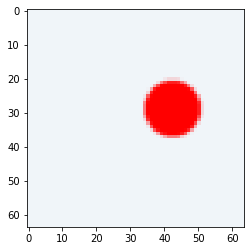

In [45]:
import matplotlib.pyplot as plt
words = list(answers_dict.keys())
nums = list(answers_dict.values())
stud.eval()
with torch.no_grad():
  image_path = test_image_paths[10]
  image = Image.open(image_path)
  # image.show()
  image = np.array(image)
  plt.imshow(image)
  image = torch.Tensor(image)
  image = image.view(1,image.shape[0],image.shape[1],image.shape[2])
  image = image.permute(0,3,1,2).to(device)
  # print(image.shape)
  q = 'what shape is present'
  ques=[]
  for i in q.split():
    ques.append(vocab[i])

  input_question = torch.Tensor(ques).long()
  
  # print(type(temp))
  input_question = input_question.view(1,-1).to(device)
  # print(input_question.shape)
  op = stud.forward(image, input_question)
  op = F.softmax(op,-1)
  a = torch.argmax(op)
  print("Question :",q)
  print("My answer to the question is : "+str(words[a]))